In [16]:
# Merge both llm_responses.json and search_results.csv

import json
import pandas as pd

# File paths
llm_responses_file = "./data/llm_responses.json"
search_results_file = "./data/search_results.csv"
merged_output_file = "./data/merged_results.json"

# Load the data
with open(llm_responses_file, "r") as f:
    llm_responses = json.load(f)

search_results = pd.read_csv(search_results_file)

# Convert titles to lowercase for case-insensitive merging
search_results["title"] = search_results["Title"].str.lower()

del search_results["Publisher"]
del search_results["Volume"]
del search_results["Issue"]
del search_results["Pages"]
del search_results["DOI"]
del search_results["Eprint"]
        
for response in llm_responses:
    response["title"] = response["title"].lower()

# Convert llm_responses to a DataFrame
llm_responses_df = pd.DataFrame(llm_responses)

# Merge the DataFrames on the title column, prioritizing search_results
merged_df = pd.merge(
    search_results,
    llm_responses_df,
    on="title",
    how="left",
    suffixes=("_search", "_llm"),
)

# Find unmatched records in llm_responses
unmatched_responses = llm_responses_df[~llm_responses_df["title"].isin(search_results["title"])]

# Print unmatched titles
if not unmatched_responses.empty:
    print("Titles in LLM responses that do not have matches in search results:")
    print("\n".join(unmatched_responses["title"].tolist()))
else:
    print("All titles in LLM responses have matches in search results.")

# Replace NaN values with null in merged DataFrame
merged_df = merged_df.where(pd.notnull(merged_df), None)

# Convert the merged DataFrame back to a JSON format
merged_data = merged_df.to_dict(orient="records")

# Save the merged data to a JSON file
with open(merged_output_file, "w", encoding="utf-8") as f:
    json.dump(merged_data, f, indent=4)

print(f"Merged results saved to {merged_output_file}")

All titles in LLM responses have matches in search results.
Merged results saved to ./data/merged_results.json


Total number of papers: 65


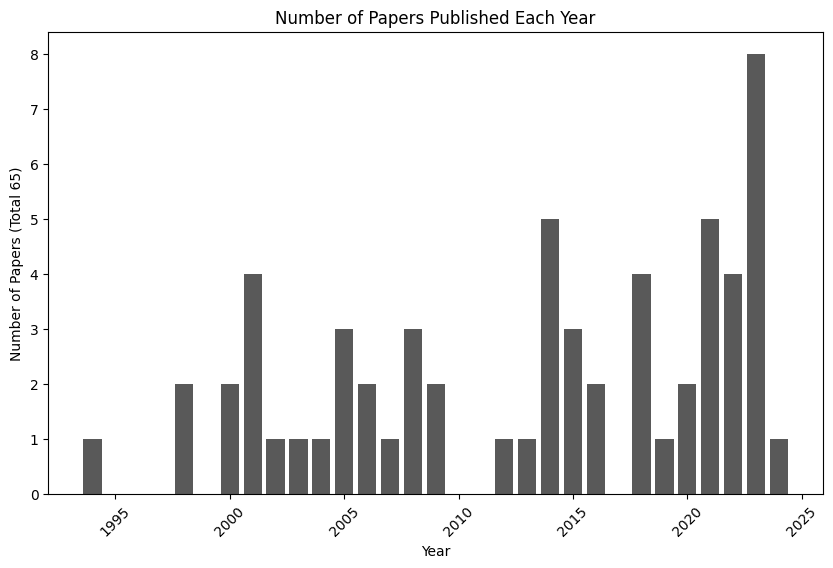

In [24]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset
with open('./data/merged_results.json') as f:
    data = json.load(f)

# Total number of papers
num_papers = len(data)
print(f"Total number of papers: {num_papers}")

# Distribution of papers by publication year
years = []
for paper in data:
    try:
        # Ensure year is valid and convert to integer
        year = int(paper['year'])
        years.append(year)
    except (ValueError, TypeError):
        # Handle invalid or missing years
        pass

year_counts = Counter(years)

# Sort years for plotting
sorted_years = sorted(year_counts.keys())
sorted_counts = [year_counts[year] for year in sorted_years]

# Plotting the distribution of papers by year
plt.figure(figsize=(10, 6))
plt.bar(sorted_years, sorted_counts, color='#595959ff')
plt.title('Number of Papers Published Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers (Total 65)')
plt.xticks(rotation=45)
plt.show()


In [42]:
# Obtain all strings to generate the fuzzy_mapper dictionaries

import json

# Load the JSON data
with open('./data/llm_responses.json') as f:
    data = json.load(f)

# Helper function to extract unique items from a field
def extract_unique_items(field):
    return set(
        item
        for paper in data
        if isinstance(paper.get(field), list)  # Ensure the field is a list
        for item in paper[field]
        if item  # Exclude None or empty values
    )

# Extract unique items for simple fields
unique_keywords = extract_unique_items('keywords')
unique_methodologies = extract_unique_items('methodologies')
unique_category_domains = extract_unique_items('category_domain')
unique_authors = set(
    author
    for paper in data
    if isinstance(paper.get('authors'), list)
    for author in paper['authors']
    if author
)
unique_performance_metrics = extract_unique_items('performance_metrics')
unique_ml_models_used = extract_unique_items('ml_models_used')
unique_datasets = extract_unique_items('datasets')

# Handle nested fields in intrusion_detection_systems
unique_ids_types = set()
unique_detection_methods = set()
unique_attack_types = set()
unique_evaluation_environments = set()

for paper in data:
    ids = paper.get('intrusion_detection_systems', {})
    if isinstance(ids.get('ids_type'), list):
        unique_ids_types.update(ids['ids_type'])
    if isinstance(ids.get('detection_methods'), list):
        unique_detection_methods.update(ids['detection_methods'])
    if isinstance(ids.get('attack_types'), list):
        unique_attack_types.update(ids['attack_types'])
    if ids.get('evaluation_environment'):
        unique_evaluation_environments.add(ids['evaluation_environment'])

# Print the unique items
print("Unique Keywords:", unique_keywords)
print()
print("Unique Methodologies:", unique_methodologies)
print()
print("Unique Category Domains:", unique_category_domains)
print()
print("Unique Authors:", unique_authors)
print()
print("Unique Performance Metrics:", unique_performance_metrics)
print()
print("Unique ML Models Used:", unique_ml_models_used)
print()
print("Unique Datasets:", unique_datasets)
print()
print("Unique IDS Types:", unique_ids_types)
print()
print("Unique Detection Methods:", unique_detection_methods)
print()
print("Unique Attack Types:", unique_attack_types)
print()
print("Unique Evaluation Environments:", unique_evaluation_environments)
print()

Unique Keywords: {'Genetic algorithm', 'Network intrusion detection', 'Mobile Agents', 'Mutual information', 'Bayesian network based detection', 'Evolutionary Computing', 'economics of IT security', 'MANET', 'CIC-IDS2017', 'One-class SVM', 'Support vector machine', 'Application-layer Protocols', 'intrusion detection system', 'AHP-TOPSIS', 'Insider Attack', 'Krill herd optimization algorithm', 'Fuzzy', 'Internet of Things', 'False Alarm Ratio', 'Data Mining', 'Cisco packet tracer', 'Network IDS', 'Artificial Neural Networks', 'network security', 'security', 'Neural Network', 'Passive Protocol Analysis', 'Deep Learning', 'Network intrusion detection systems (NIDS)', 'Optimization', 'Particle Swarm Optimization', 'anomaly detection', 'Classification and Regression Trees', 'system call', 'acquaintance management', 'Information Security', 'Principal Component Analysis', 'Intrusion Detection System', 'Pairwise learning', 'classifier machine learning', 'data mining', 'Sampling', 'Decision tre

Top Methodologies: [('Feature Selection', 6), ('Decision Trees', 5), ('Machine Learning', 5), ('Anomaly Detection', 3), ('Least Square Support Vector Machine', 2), ('Misuse Detection', 2), ('Decision Tree', 2), ('Particle Swarm Optimization', 2), ('Ensemble Learning', 2), ('Hierarchical IDS', 1)]
Top Keywords: [('Intrusion Detection', 12), ('Intrusion Detection Systems', 8), ('Intrusion detection', 8), ('Network Security', 5), ('Intrusion detection systems', 5), ('Machine learning', 5), ('intrusion detection', 4), ('Cybersecurity', 4), ('Intrusion Detection System', 4), ('Machine Learning', 3)]


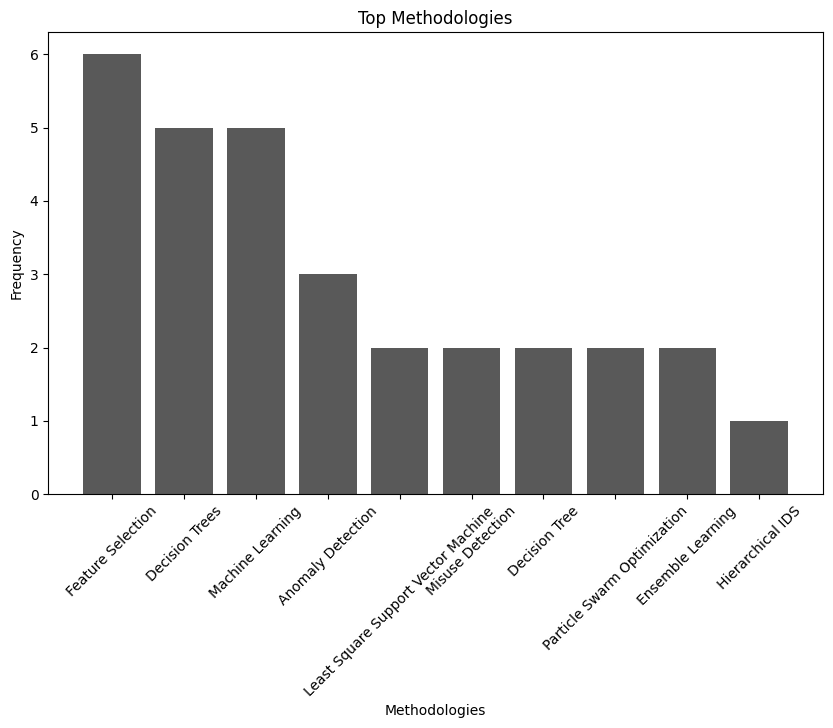

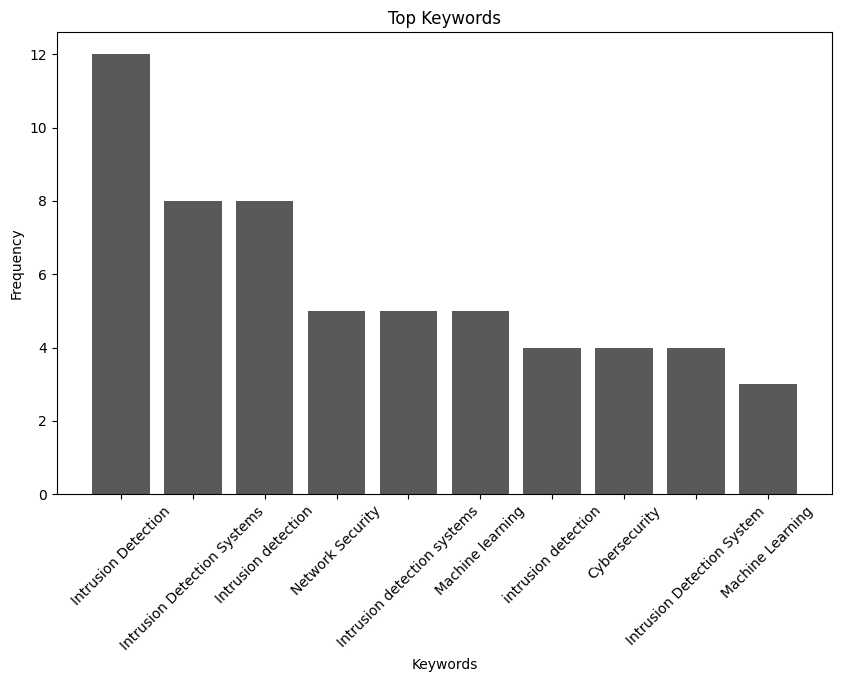

In [26]:
# Most frequently mentioned methodologies and keywords
methodologies = [method for paper in data for method in paper.get('methodologies', []) if method]
keywords = [kw for paper in data for kw in paper.get('keywords', []) if kw]

method_counts = Counter(methodologies).most_common(10)
keyword_counts = Counter(keywords).most_common(10)

# Print top methodologies and keywords
print("Top Methodologies:", method_counts)
print("Top Keywords:", keyword_counts)

# Plotting top methodologies
plt.figure(figsize=(10, 6))
plt.bar([m[0] for m in method_counts], [m[1] for m in method_counts], color='#595959ff')
plt.title('Top Methodologies')
plt.xlabel('Methodologies')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

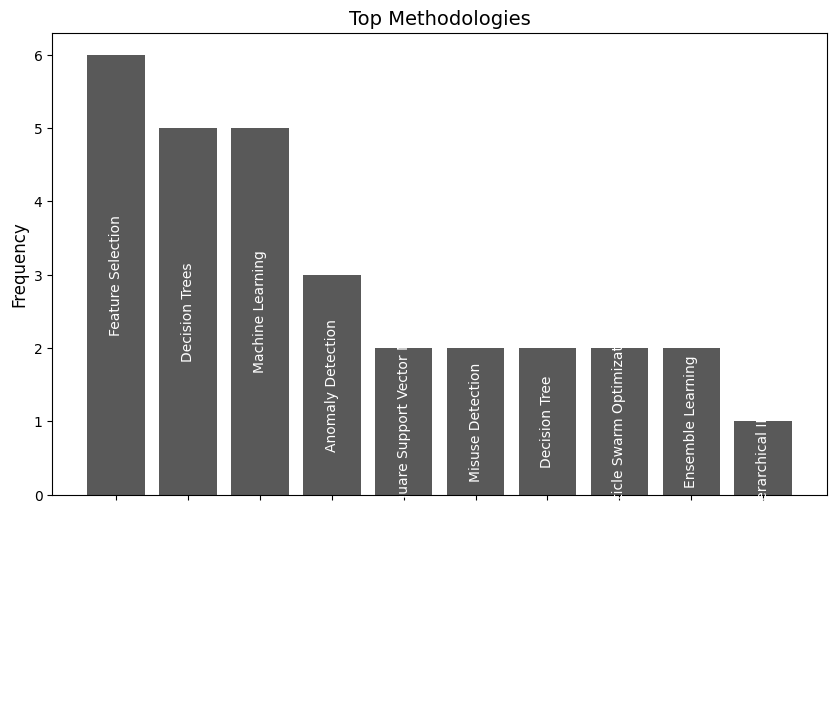

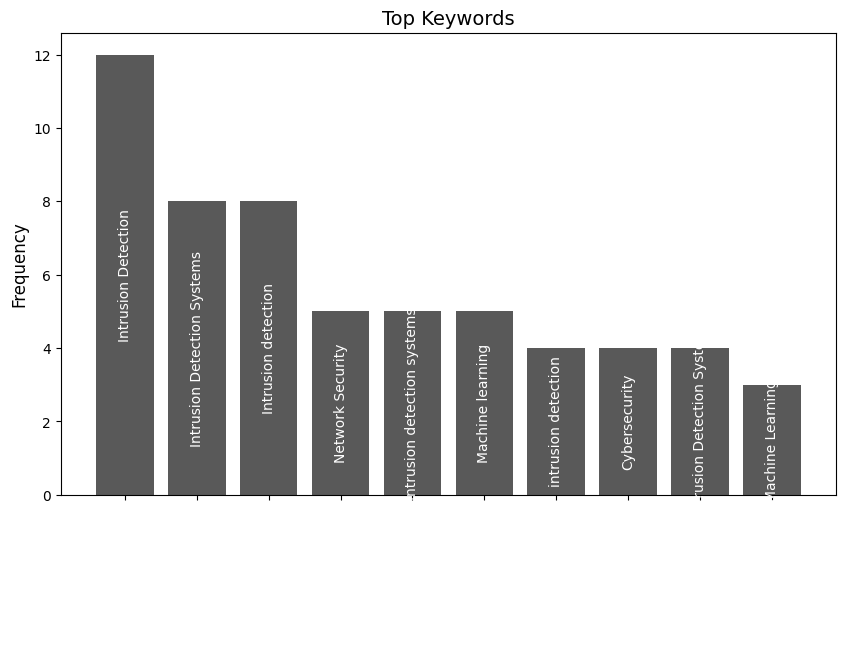

In [38]:
import matplotlib.pyplot as plt
from collections import Counter

# Helper function to add labels (keywords/methodologies) inside bars
def add_labels(ax, bars, labels):
    for bar, label in zip(bars, labels):
        if bar.get_height() > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center of the bar
                bar.get_height() / 2,  # Place the label inside the bar
                label,  # Text to display (keyword/methodology)
                ha='center', va='center', rotation=90, color='white', fontsize=10
            )

# Plotting top methodologies
plt.figure(figsize=(10, 6))
method_counts = Counter(methodologies).most_common(10)
method_labels = [m[0] for m in method_counts]
method_frequencies = [m[1] for m in method_counts]

bars = plt.bar(method_labels, method_frequencies, color='#595959ff')
plt.title('Top Methodologies', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, fontsize=10, color='white')  # White x-label text

# Add methodology labels inside bars
ax = plt.gca()
add_labels(ax, bars, method_labels)

plt.show()

# Plotting top keywords
plt.figure(figsize=(10, 6))
keyword_counts = Counter(keywords).most_common(10)
keyword_labels = [k[0] for k in keyword_counts]
keyword_frequencies = [k[1] for k in keyword_counts]

bars = plt.bar(keyword_labels, keyword_frequencies, color='#595959ff')
plt.title('Top Keywords', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, fontsize=10, color='white')  # White x-label text

# Add keyword labels inside bars
ax = plt.gca()
add_labels(ax, bars, keyword_labels)

plt.show()